# Description

This notebook runs some pre-analyses using spectral clustering to explore the best set of parameters to cluster `pca` data version.

# Environment variables

In [1]:
from IPython.display import display

import conf

N_JOBS = conf.GENERAL["N_JOBS"]
display(N_JOBS)

3

In [2]:
%env MKL_NUM_THREADS=$N_JOBS
%env OPEN_BLAS_NUM_THREADS=$N_JOBS
%env NUMEXPR_NUM_THREADS=$N_JOBS
%env OMP_NUM_THREADS=$N_JOBS

env: MKL_NUM_THREADS=3
env: OPEN_BLAS_NUM_THREADS=3
env: NUMEXPR_NUM_THREADS=3
env: OMP_NUM_THREADS=3


# Modules loading

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns

from utils import generate_result_set_name

# Settings

In [5]:
INITIAL_RANDOM_STATE = 40000

# PCA

In [6]:
INPUT_SUBSET = "pca"

In [7]:
INPUT_STEM = "z_score_std-projection-smultixcan-efo_partial-mashr-zscores"

In [8]:
DR_OPTIONS = {
    "n_components": 50,
    "svd_solver": "full",
    "random_state": 0,
}

In [9]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    generate_result_set_name(
        DR_OPTIONS, prefix=f"{INPUT_SUBSET}-{INPUT_STEM}-", suffix=".pkl"
    ),
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base3/results/data_transformations/pca/pca-z_score_std-projection-smultixcan-efo_partial-mashr-zscores-n_components_50-random_state_0-svd_solver_full.pkl')

'pca-z_score_std-projection-smultixcan-efo_partial-mashr-zscores-n_components_50-random_state_0-svd_solver_full'

In [10]:
data = pd.read_pickle(input_filepath)

In [11]:
data.shape

(3749, 50)

In [12]:
data.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,...,PCA41,PCA42,PCA43,PCA44,PCA45,PCA46,PCA47,PCA48,PCA49,PCA50
100001_raw-Food_weight,-0.547515,-0.007250,0.245361,0.132424,1.201447,-0.113158,0.048859,1.031679,0.711208,0.126100,...,0.113685,-0.109753,0.178202,-0.487868,1.805920,-0.342611,-0.663712,-1.313987,-1.481707,0.396410
100002_raw-Energy,-1.570593,-0.618992,-1.223395,1.627321,-0.563860,0.224922,-1.500327,2.045633,-1.665998,-0.180432,...,0.697880,1.412676,2.103988,0.385625,2.386495,-2.939998,-0.978275,-1.893307,-0.259497,0.423264
100003_raw-Protein,-0.601212,-0.948824,-1.022209,2.438433,-2.062235,0.356202,-1.538038,2.314675,-1.108991,0.318034,...,0.171992,1.351979,0.054404,-0.725132,2.226520,-3.481674,-0.445294,-0.477452,0.237157,1.440867
100004_raw-Fat,-1.648214,-0.342042,-0.270189,1.683268,-1.222401,0.018349,-0.032824,1.671161,-0.908965,0.224100,...,-0.358812,0.696836,1.072624,0.627951,1.802000,0.174704,0.826319,-0.826992,0.596113,0.620050
100005_raw-Carbohydrate,-1.867586,-0.006412,-0.303220,0.770958,-0.116822,0.460946,-2.407732,1.534273,-1.930577,0.064621,...,1.332852,1.978032,2.158456,0.831123,1.093202,-3.539033,-0.831862,-0.842298,-0.723072,0.359438


# Clustering

In [13]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score

## `gamma` parameter

### Using default value (`gamma=1.0`)

In [14]:
with warnings.catch_warnings():
    warnings.filterwarnings("always")

    clus = SpectralClustering(
        eigen_solver="arpack",
        eigen_tol=1e-3,
        n_clusters=2,
        n_init=1,
        affinity="rbf",
        gamma=1.00,
        random_state=INITIAL_RANDOM_STATE,
    )

    part = clus.fit_predict(data)

/mnt/software/miniconda3/envs/phenoplier/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [15]:
# show number of clusters and their size
pd.Series(part).value_counts()

0    3748
1       1
dtype: int64

For default values of `gamma` (`1.0`), the algorithm takes a lot of time to converge (here I used `eigen_tol=1e-03` to force convergence).

### Using `gamma=0.01`

In [16]:
with warnings.catch_warnings():
    warnings.filterwarnings("always")

    clus = SpectralClustering(
        eigen_solver="arpack",
        eigen_tol=1e-3,
        n_clusters=2,
        n_init=1,
        affinity="rbf",
        gamma=0.01,
        random_state=INITIAL_RANDOM_STATE,
    )

    part = clus.fit_predict(data)

In [17]:
# show number of clusters and their size
pd.Series(part).value_counts()

0    3748
1       1
dtype: int64

For values around `gamma=0.01` the algorithm takes a lot of time to converge (here I used `eigen_tol=1e-03` to force convergence).

### Using `gamma=0.001`

In [18]:
with warnings.catch_warnings():
    warnings.filterwarnings("always")

    clus = SpectralClustering(
        eigen_solver="arpack",
        #         eigen_tol=1e-3,
        n_clusters=2,
        n_init=1,
        affinity="rbf",
        gamma=0.001,
        random_state=INITIAL_RANDOM_STATE,
    )

    part = clus.fit_predict(data)

In [19]:
# show number of clusters and their size
pd.Series(part).value_counts()

0    3747
1       2
dtype: int64

In [20]:
# From sklearn website:
# The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters.
# Negative values generally indicate that a sample has been assigned to the wrong cluster,
# as a different cluster is more similar
silhouette_score(data, part)

0.8344842879459312

In [21]:
# From sklearn website:
# The score is defined as ratio between the within-cluster dispersion and the between-cluster dispersion
calinski_harabasz_score(data, part)

83.0506773913528

For values around `gamma=0.001` now the algorithm converges. This suggests smaller values should be explored for this parameter.

## Extended test

In [22]:
CLUSTERING_OPTIONS = {}

CLUSTERING_OPTIONS["K_RANGE"] = [2, 4, 6, 8, 10, 20, 30, 40, 50, 60]
CLUSTERING_OPTIONS["N_REPS_PER_K"] = 5
CLUSTERING_OPTIONS["KMEANS_N_INIT"] = 10
CLUSTERING_OPTIONS["GAMMAS"] = [
    1e-03,
    #     1e-04,
    #     1e-05,
    1e-05,
    #     1e-06,
    #     1e-07,
    #     1e-08,
    #     1e-09,
    1e-10,
    #     1e-11,
    #     1e-12,
    #     1e-13,
    #     1e-14,
    1e-15,
    1e-17,
    1e-20,
    1e-30,
    1e-40,
    1e-50,
]
CLUSTERING_OPTIONS["AFFINITY"] = "rbf"

display(CLUSTERING_OPTIONS)

{'K_RANGE': [2, 4, 6, 8, 10, 20, 30, 40, 50, 60],
 'N_REPS_PER_K': 5,
 'KMEANS_N_INIT': 10,
 'GAMMAS': [0.001, 1e-05, 1e-10, 1e-15, 1e-17, 1e-20, 1e-30, 1e-40, 1e-50],
 'AFFINITY': 'rbf'}

In [23]:
CLUSTERERS = {}

idx = 0
random_state = INITIAL_RANDOM_STATE

for k in CLUSTERING_OPTIONS["K_RANGE"]:
    for gamma_value in CLUSTERING_OPTIONS["GAMMAS"]:
        for i in range(CLUSTERING_OPTIONS["N_REPS_PER_K"]):
            clus = SpectralClustering(
                eigen_solver="arpack",
                n_clusters=k,
                n_init=CLUSTERING_OPTIONS["KMEANS_N_INIT"],
                affinity=CLUSTERING_OPTIONS["AFFINITY"],
                gamma=gamma_value,
                random_state=random_state,
            )

            method_name = type(clus).__name__
            CLUSTERERS[f"{method_name} #{idx}"] = clus

            random_state = random_state + 1
            idx = idx + 1

In [24]:
display(len(CLUSTERERS))

450

In [25]:
_iter = iter(CLUSTERERS.items())
display(next(_iter))
display(next(_iter))

('SpectralClustering #0',
 SpectralClustering(eigen_solver='arpack', gamma=0.001, n_clusters=2,
                    random_state=40000))

('SpectralClustering #1',
 SpectralClustering(eigen_solver='arpack', gamma=0.001, n_clusters=2,
                    random_state=40001))

In [26]:
clustering_method_name = method_name
display(clustering_method_name)

'SpectralClustering'

## Generate ensemble

In [27]:
import tempfile
from clustering.ensemble import generate_ensemble

In [28]:
# generate a temporary folder where to store the ensemble and avoid computing it again
ensemble_folder = Path(
    tempfile.gettempdir(),
    f"pre_cluster_analysis",
    clustering_method_name,
).resolve()
ensemble_folder.mkdir(parents=True, exist_ok=True)

In [29]:
ensemble_file = Path(
    ensemble_folder,
    generate_result_set_name(
        CLUSTERING_OPTIONS, prefix=f"ensemble-{INPUT_SUBSET}-", suffix=".pkl"
    ),
)
display(ensemble_file)

PosixPath('/tmp/pre_cluster_analysis/SpectralClustering/ensemble-pca-AFFINITY_rbf-GAMMAS_0001_1e_05_1e_10_1e_15_1e_17_1e_20_1e_30_1e_40_1e_50-KMEANS_N_INIT_10-K_RANGE_2_4_6_8_10_20_30_40_50_60-N_REPS_PER_K_5.pkl')

In [30]:
if ensemble_file.exists():
    display(f"Ensemble file exists")
    ensemble = pd.read_pickle(ensemble_file)
else:
    ensemble = generate_ensemble(
        data,
        CLUSTERERS,
        attributes=["n_clusters", "gamma"],
    )

    ensemble.to_pickle(ensemble_file)

100%|██████████| 450/450 [19:29<00:00,  2.60s/it]


In [31]:
ensemble.shape

(450, 4)

In [32]:
ensemble.head()

,clusterer_params,partition,n_clusters,gamma
clusterer_id,,,,
SpectralClustering #0,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,0.001
SpectralClustering #1,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,0.001
SpectralClustering #2,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,0.001
SpectralClustering #3,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,0.001
SpectralClustering #4,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,0.001


In [33]:
ensemble["gamma"] = ensemble["gamma"].apply(lambda x: f"{x:.1e}")

In [34]:
ensemble["n_clusters"].value_counts()

60    45
50    45
40    45
30    45
20    45
10    45
8     45
6     45
4     45
2     45
Name: n_clusters, dtype: int64

In [35]:
_tmp = ensemble["n_clusters"].value_counts().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == int(
    CLUSTERING_OPTIONS["N_REPS_PER_K"] * len(CLUSTERING_OPTIONS["GAMMAS"])
)

In [36]:
ensemble_stats = ensemble["n_clusters"].describe()
display(ensemble_stats)

count    450.000000
mean      23.000000
std       19.846291
min        2.000000
25%        6.000000
50%       15.000000
75%       40.000000
max       60.000000
Name: n_clusters, dtype: float64

### Testing

In [37]:
assert ensemble_stats["min"] > 1

In [38]:
assert not ensemble["n_clusters"].isna().any()

In [39]:
assert ensemble.shape[0] == len(CLUSTERERS)

In [40]:
# all partitions have the right size
assert np.all(
    [part["partition"].shape[0] == data.shape[0] for idx, part in ensemble.iterrows()]
)

In [41]:
# no partition has negative clusters (noisy points)
assert not np.any([(part["partition"] < 0).any() for idx, part in ensemble.iterrows()])

In [42]:
# check that the number of clusters in the partitions are the expected ones
_real_k_values = ensemble["partition"].apply(lambda x: np.unique(x).shape[0])
display(_real_k_values)
assert np.all(ensemble["n_clusters"].values == _real_k_values.values)

clusterer_id
SpectralClustering #0       2
SpectralClustering #1       2
SpectralClustering #2       2
SpectralClustering #3       2
SpectralClustering #4       2
                           ..
SpectralClustering #445    60
SpectralClustering #446    60
SpectralClustering #447    60
SpectralClustering #448    60
SpectralClustering #449    60
Name: partition, Length: 450, dtype: int64

### Add clustering quality measures

In [43]:
ensemble = ensemble.assign(
    ch_score=ensemble["partition"].apply(lambda x: calinski_harabasz_score(data, x))
)

In [44]:
ensemble.shape

(450, 5)

In [45]:
ensemble.head()

,clusterer_params,partition,n_clusters,gamma,ch_score
clusterer_id,,,,,
SpectralClustering #0,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1.0e-03,83.050677
SpectralClustering #1,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1.0e-03,83.050677
SpectralClustering #2,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1.0e-03,83.050677
SpectralClustering #3,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1.0e-03,83.050677
SpectralClustering #4,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1.0e-03,83.050677


# Cluster quality

In [46]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    _df = ensemble.groupby(["n_clusters", "gamma"]).mean()
    display(_df)

ch_score
n_clusters gamma              
2          1.0e-03   83.050677
           1.0e-05  920.960250
           1.0e-10  920.960250
           1.0e-15  920.712849
           1.0e-17    0.696771
           1.0e-20    0.769604
           1.0e-30    0.566860
           1.0e-40    1.379595
           1.0e-50    2.155884
4          1.0e-03  104.013981
           1.0e-05  440.625985
           1.0e-10  459.829090
           1.0e-15  460.093578
           1.0e-17    1.255593
           1.0e-20    1.204769
           1.0e-30    0.770666
           1.0e-40    1.028757
           1.0e-50    1.278531
6          1.0e-03   98.307777
           1.0e-05  407.262596
           1.0e-10  407.139155
           1.0e-15  403.352012
           1.0e-17    3.938523
           1.0e-20    1.382317
           1.0e-30    0.709304
           1.0e-40    1.148510
           1.0e-50    0.595956
8          1.0e-03   86.619457
           1.0e-05  352.426508
           1.0e-10  352.288219
           1.0e-15  351.101374
           1.0e-17    1.536417
           1.0e-20    0.775072
           1.0e-30    1.415835
           1.0e-40    0.991826
           1.0e-50    1.811312
10         1.0e-03   79.213966
           1.0e-05  305.235778
           1.0e-10  303.906036
           1.0e-15  303.308943
           1.0e-17    3.129922
           1.0e-20    0.710854
           1.0e-30    0.776999
           1.0e-40    1.117309
           1.0e-50    0.792008
20         1.0e-03   85.953734
           1.0e-05  226.120341
           1.0e-10  226.418508
           1.0e-15  220.505347
           1.0e-17    2.316251
           1.0e-20    1.050538
           1.0e-30    1.095656
           1.0e-40    1.136374
           1.0e-50    1.354302
30         1.0e-03   97.878303
           1.0e-05  185.839688
           1.0e-10  180.005955
           1.0e-15  167.187336
           1.0e-17    1.764371
           1.0e-20    0.947018
           1.0e-30    1.316543
           1.0e-40    1.091501
           1.0e-50    1.239932
40         1.0e-03   89.353104
           1.0e-05  154.992139
           1.0e-10  155.467888
           1.0e-15  136.323625
           1.0e-17    1.800659
           1.0e-20    1.127432
           1.0e-30    1.339679
           1.0e-40    0.984259
           1.0e-50    1.291544
50         1.0e-03   87.490018
           1.0e-05  134.991487
           1.0e-10  135.096376
           1.0e-15  114.408248
           1.0e-17    1.827527
           1.0e-20    1.105509
           1.0e-30    1.317762
           1.0e-40    1.241946
           1.0e-50    1.146558
60         1.0e-03   87.985274
           1.0e-05  113.389752
           1.0e-10  113.425645
           1.0e-15   94.265890
           1.0e-17    1.790338
           1.0e-20    1.048279
           1.0e-30    1.216626
           1.0e-40    0.853725
           1.0e-50    1.035743

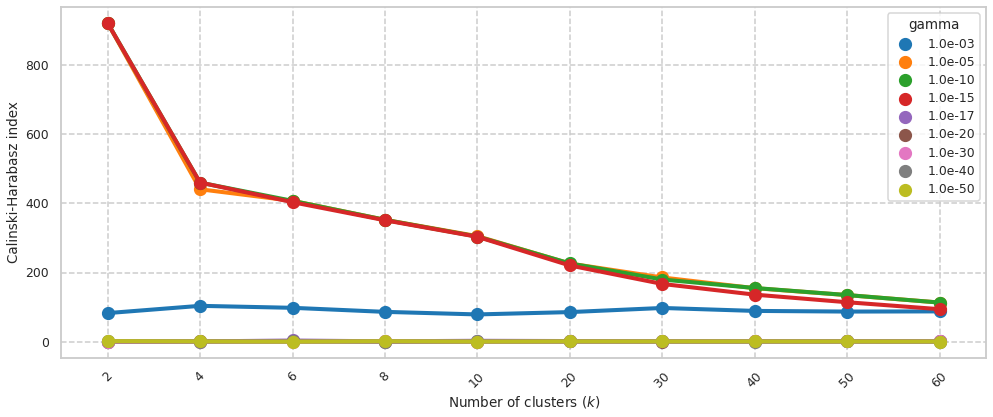

In [47]:
# with sns.axes_style('whitegrid', {'grid.linestyle': '--'}):
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=ensemble, x="n_clusters", y="ch_score", hue="gamma")
    ax.set_ylabel("Calinski-Harabasz index")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    #     ax.set_ylim(0.0, 1.0)
    #     ax.set_xlim(CLUSTERING_OPTIONS['K_MIN'], CLUSTERING_OPTIONS['K_MAX'])
    plt.grid(True)
    plt.tight_layout()

# Stability

## Group ensemble by n_clusters

In [48]:
parts = ensemble.groupby(["gamma", "n_clusters"]).apply(
    lambda x: np.concatenate(x["partition"].apply(lambda x: x.reshape(1, -1)), axis=0)
)

In [49]:
parts.shape

(90,)

In [50]:
parts.head()

gamma    n_clusters
1.0e-03  2             [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
         4             [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
         6             [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
         8             [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
         10            [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
dtype: object

In [51]:
parts.iloc[0].shape

(5, 3749)

In [52]:
assert np.all(
    [
        parts.loc[k].shape == (int(CLUSTERING_OPTIONS["N_REPS_PER_K"]), data.shape[0])
        for k in parts.index
    ]
)

## Compute stability

In [53]:
from sklearn.metrics import adjusted_rand_score as ari
from scipy.spatial.distance import squareform, pdist

In [54]:
parts_ari = pd.Series(
    {k: pdist(parts.loc[k], metric=ari) for k in parts.index}, name="n_clusters"
)

In [55]:
parts_ari_stability = parts_ari.apply(lambda x: x.mean())
display(parts_ari_stability.sort_values(ascending=False).head(15))

1.0e-03  2     1.000000
         10    1.000000
1.0e-10  8     1.000000
         6     1.000000
         2     1.000000
1.0e-05  6     1.000000
         2     1.000000
         8     1.000000
1.0e-03  8     1.000000
         4     1.000000
         6     1.000000
1.0e-10  4     0.997383
1.0e-05  4     0.997230
1.0e-15  2     0.996823
1.0e-05  10    0.990633
Name: n_clusters, dtype: float64

In [56]:
parts_ari_df = pd.DataFrame.from_records(parts_ari.tolist()).set_index(
    parts_ari.index.copy()
)
parts_ari_df.index.rename(["gamma", "n_clusters"], inplace=True)

In [57]:
parts_ari_df.shape

(90, 10)

In [58]:
_n_total_parts = int(
    CLUSTERING_OPTIONS["N_REPS_PER_K"]
)  # * len(CLUSTERING_OPTIONS["GAMMAS"]))

assert int(_n_total_parts * (_n_total_parts - 1) / 2) == parts_ari_df.shape[1]

In [59]:
parts_ari_df.head()

0    1    2    3    4    5    6    7    8    9
gamma   n_clusters                                                  
1.0e-03 2           1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
        4           1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
        6           1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
        8           1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
        10          1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

## Stability plot

In [60]:
parts_ari_df_plot = (
    parts_ari_df.stack().reset_index().rename(columns={"level_2": "idx", 0: "ari"})
)

In [61]:
parts_ari_df_plot.dtypes

gamma          object
n_clusters      int64
idx             int64
ari           float64
dtype: object

In [62]:
parts_ari_df_plot.head()

,gamma,n_clusters,idx,ari
0,1.0e-03,2,0,1.0
1,1.0e-03,2,1,1.0
2,1.0e-03,2,2,1.0
3,1.0e-03,2,3,1.0
4,1.0e-03,2,4,1.0


In [63]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    _df = parts_ari_df_plot.groupby(["n_clusters", "gamma"]).mean()
    display(_df)

idx       ari
n_clusters gamma                 
2          1.0e-03  4.5  1.000000
           1.0e-05  4.5  1.000000
           1.0e-10  4.5  1.000000
           1.0e-15  4.5  0.996823
           1.0e-17  4.5 -0.001536
           1.0e-20  4.5  0.000975
           1.0e-30  4.5 -0.000739
           1.0e-40  4.5  0.007904
           1.0e-50  4.5  0.003361
4          1.0e-03  4.5  1.000000
           1.0e-05  4.5  0.997230
           1.0e-10  4.5  0.997383
           1.0e-15  4.5  0.967827
           1.0e-17  4.5  0.002210
           1.0e-20  4.5  0.002405
           1.0e-30  4.5  0.002085
           1.0e-40  4.5 -0.000608
           1.0e-50  4.5 -0.003069
6          1.0e-03  4.5  1.000000
           1.0e-05  4.5  1.000000
           1.0e-10  4.5  1.000000
           1.0e-15  4.5  0.912974
           1.0e-17  4.5 -0.000844
           1.0e-20  4.5  0.007494
           1.0e-30  4.5  0.004192
           1.0e-40  4.5 -0.003611
           1.0e-50  4.5 -0.002141
8          1.0e-03  4.5  1.000000
           1.0e-05  4.5  1.000000
           1.0e-10  4.5  1.000000
           1.0e-15  4.5  0.931346
           1.0e-17  4.5  0.006473
           1.0e-20  4.5 -0.001073
           1.0e-30  4.5 -0.002034
           1.0e-40  4.5  0.000525
           1.0e-50  4.5  0.008244
10         1.0e-03  4.5  1.000000
           1.0e-05  4.5  0.990633
           1.0e-10  4.5  0.990155
           1.0e-15  4.5  0.804388
           1.0e-17  4.5  0.006414
           1.0e-20  4.5 -0.002171
           1.0e-30  4.5  0.003226
           1.0e-40  4.5  0.008120
           1.0e-50  4.5  0.002680
20         1.0e-03  4.5  0.972892
           1.0e-05  4.5  0.499832
           1.0e-10  4.5  0.638118
           1.0e-15  4.5  0.123910
           1.0e-17  4.5  0.005072
           1.0e-20  4.5 -0.000224
           1.0e-30  4.5  0.006978
           1.0e-40  4.5 -0.003408
           1.0e-50  4.5  0.002813
30         1.0e-03  4.5  0.971791
           1.0e-05  4.5  0.316773
           1.0e-10  4.5  0.280382
           1.0e-15  4.5  0.054671
           1.0e-17  4.5  0.003145
           1.0e-20  4.5  0.000601
           1.0e-30  4.5  0.001525
           1.0e-40  4.5  0.003000
           1.0e-50  4.5  0.009797
40         1.0e-03  4.5  0.980744
           1.0e-05  4.5  0.182454
           1.0e-10  4.5  0.171947
           1.0e-15  4.5  0.044524
           1.0e-17  4.5  0.002408
           1.0e-20  4.5 -0.003788
           1.0e-30  4.5  0.001295
           1.0e-40  4.5  0.000734
           1.0e-50  4.5  0.002676
50         1.0e-03  4.5  0.631445
           1.0e-05  4.5  0.139879
           1.0e-10  4.5  0.123279
           1.0e-15  4.5  0.039099
           1.0e-17  4.5  0.002170
           1.0e-20  4.5  0.006595
           1.0e-30  4.5 -0.001275
           1.0e-40  4.5  0.002134
           1.0e-50  4.5  0.003881
60         1.0e-03  4.5  0.090087
           1.0e-05  4.5  0.120703
           1.0e-10  4.5  0.126477
           1.0e-15  4.5  0.037412
           1.0e-17  4.5  0.008318
           1.0e-20  4.5  0.006606
           1.0e-30  4.5 -0.000967
           1.0e-40  4.5  0.001881
           1.0e-50  4.5  0.005270

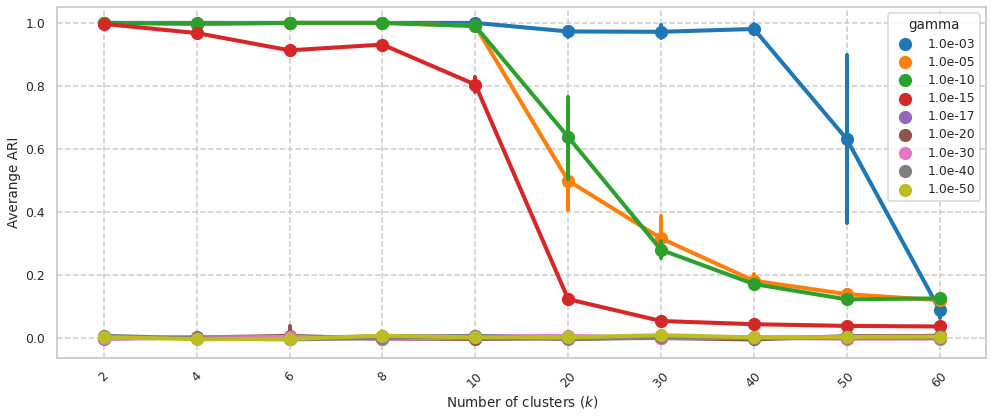

In [64]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=parts_ari_df_plot, x="n_clusters", y="ari", hue="gamma")
    ax.set_ylabel("Averange ARI")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()

**CONCLUSION:** We choose `1e-10` as the `gamma` parameter for this data version.